In [ ]:
'''
TODO:
dependincies smokiing vs Hx
compare age to savrity of cancer - Stage
age-smoking
Outliers: test features combined with Agehttps://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets/notebook
compare gender on each feature
add plot from paper - done
read paper
check which categries can be converted to numbers (like stage) - should use one hot encoding
deal which classes that have low numbers of participants (like stage >3)
'''

**IMPORTS**

In [68]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import os
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")


*The Dataframe*

In [70]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
shared_folder_path = '/content/drive/My Drive/tables_data'
os.chdir(shared_folder_path)
df = pd.read_csv('Thyroid_Dataset.csv')

Mounted at /content/drive


                                                                      Data Analysis And Visualization

In [9]:
df.head(3)

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No


*Skew*

TODO: relevat only for Age(?) should covert all claess to numeric for calculate skew(?) video 4 20 last mins, just mentioned shorlty




In [58]:
df.skew()

Age    0.719732
dtype: float64

Age is positive skewed

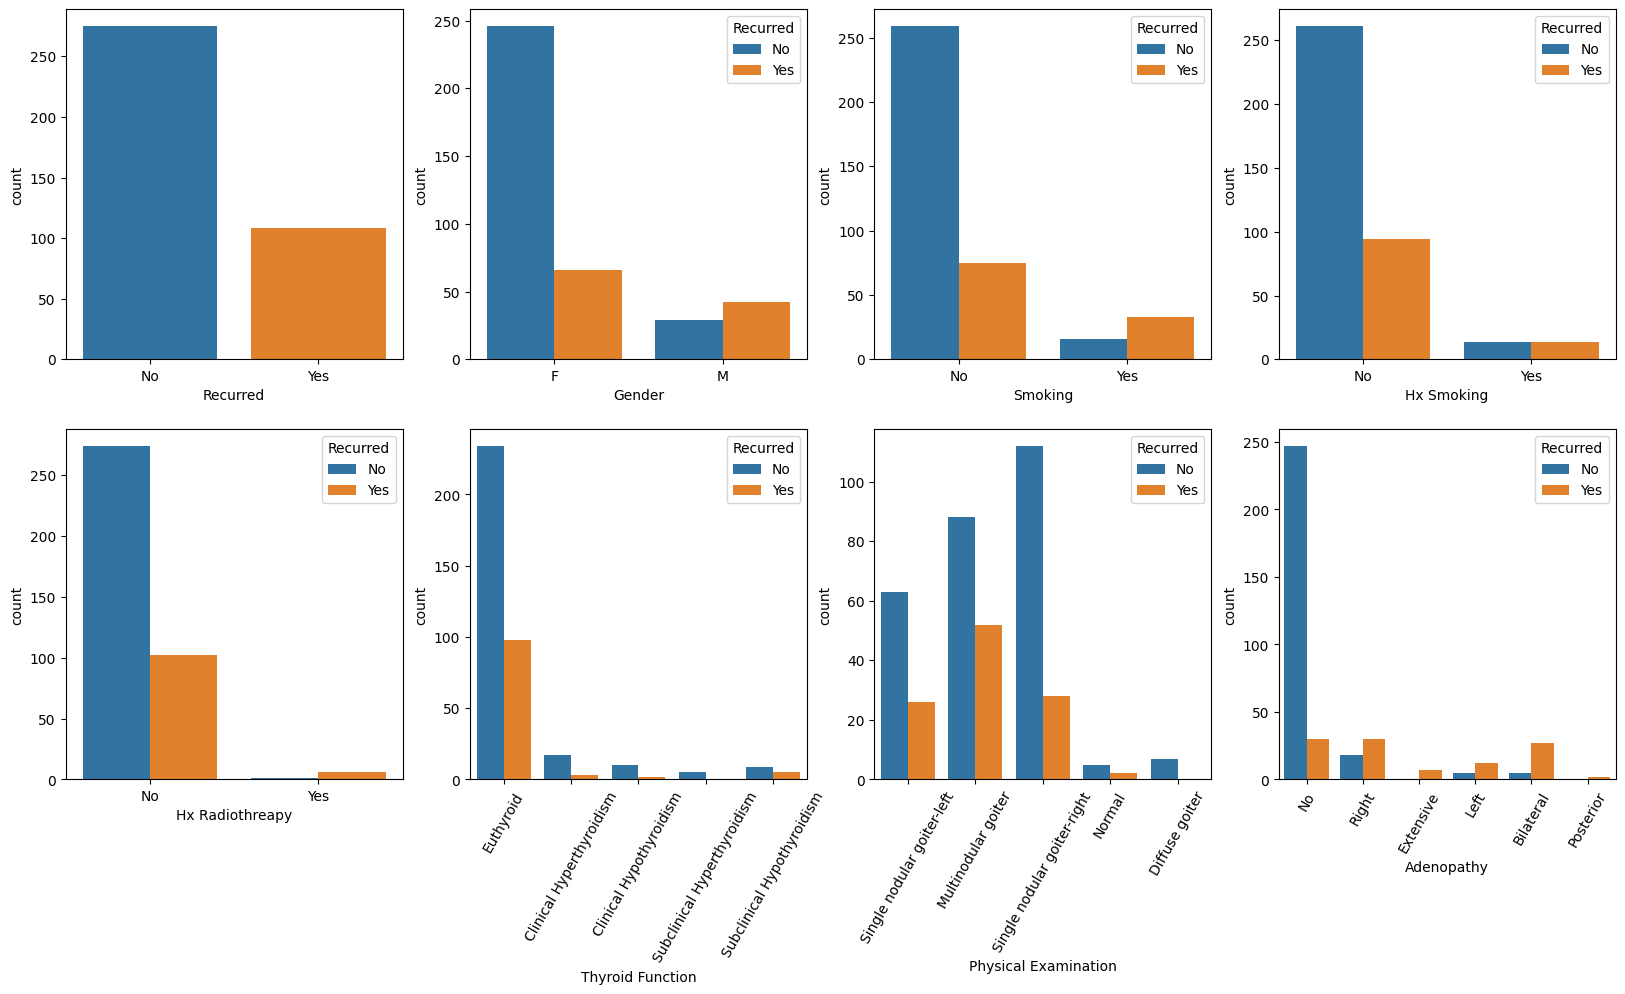

In [10]:
plt.figure(figsize=(20,10))
plt.subplot(241)
sns.countplot(df, x='Recurred', hue='Recurred')
plt.subplot(242)
sns.countplot(df, x='Gender', hue='Recurred')
plt.subplot(243)
sns.countplot(df, x='Smoking', hue='Recurred')
plt.subplot(244)
sns.countplot(df, x='Hx Smoking', hue='Recurred')
plt.subplot(245)
sns.countplot(df, x='Hx Radiothreapy', hue ='Recurred')
plt.subplot(246)
sns.countplot(df, x='Thyroid Function', hue='Recurred')
plt.xticks(rotation=60)
plt.subplot(247)
sns.countplot(df, x='Physical Examination', hue='Recurred')
plt.xticks(rotation=60)
plt.subplot(248)
sns.countplot(df, x='Adenopathy', hue='Recurred')
plt.xticks(rotation=60)
plt.show()

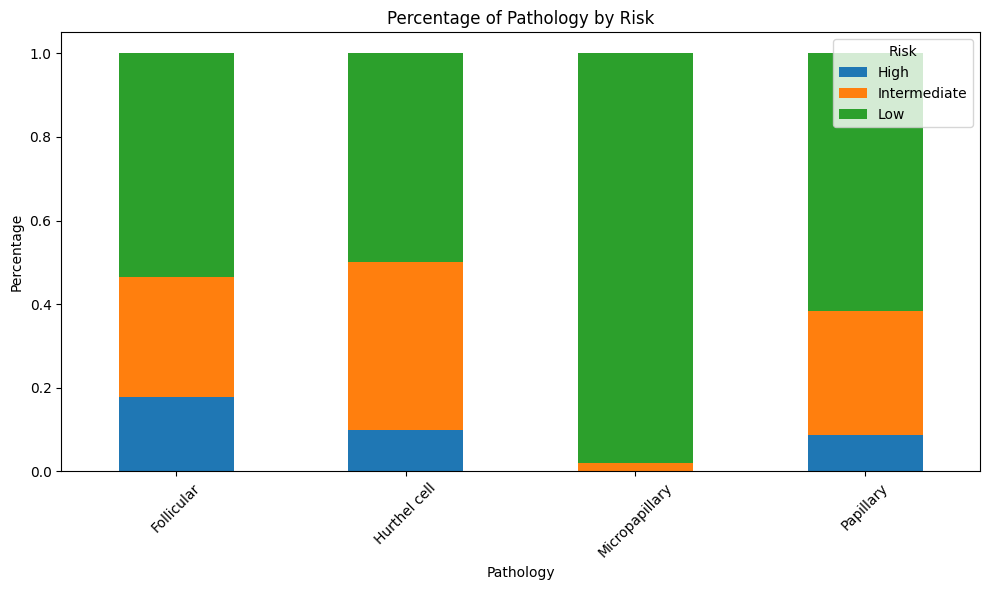

In [11]:
# Convert data to DataFrame
df = pd.DataFrame(df)

# Calculate percentages
total_counts = df.groupby('Pathology').size()
grouped_counts = df.groupby(['Pathology', 'Risk']).size()
percentages = (grouped_counts / total_counts).unstack(fill_value=0)

# Plot
percentages.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Percentage of Pathology by Risk')
plt.xlabel('Pathology')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Risk')
plt.tight_layout()
plt.show()

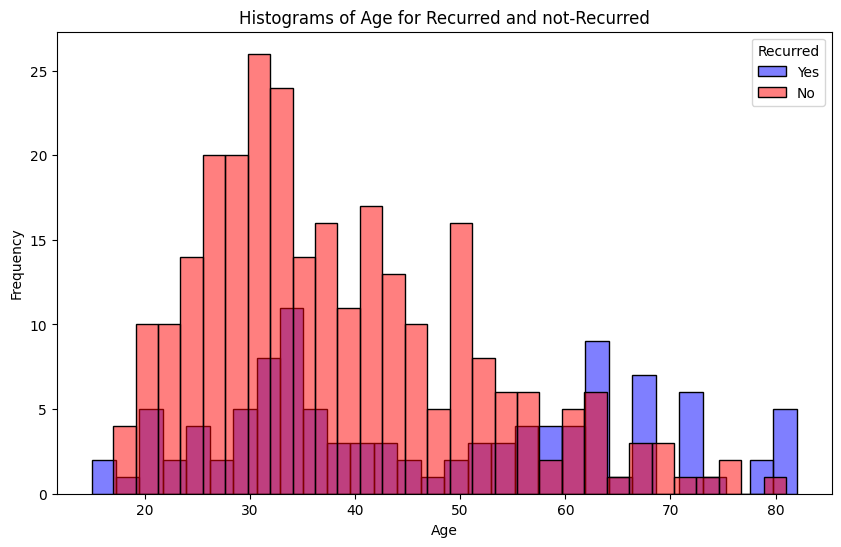

In [12]:

df_y = df[df['Recurred'] == 'Yes']
df_n = df[df['Recurred'] == 'No']

plt.figure(figsize=(10, 6))
sns.histplot(df_y['Age'], color='blue', label='Yes', bins=30, alpha=0.5)
sns.histplot(df_n['Age'], color='red', label='No', bins=30, alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histograms of Age for Recurred and not-Recurred')
plt.legend(title='Recurred')
plt.show()

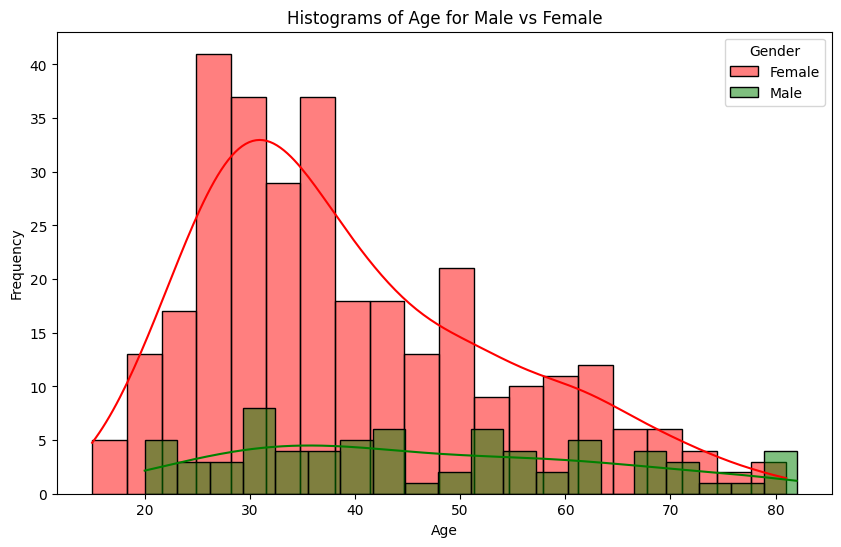

In [65]:
df_female = df[df['Gender'] == 'F']
df_male = df[df['Gender'] == 'M']

plt.figure(figsize=(10, 6))
sns.histplot(df_female['Age'], color='red', label='Female', kde=True, bins=20, alpha=0.5)
sns.histplot(df_male['Age'], color='green', label='Male', kde=True, bins=20, alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histograms of Age for Male vs Female')
plt.legend(title='Gender')
plt.show()

In addiotion to the skew value we claculted above, we can also see that  gender and age distribution is positive skewed

In [ ]:
import curses

def draw_histogram(stdscr, data):
    height, width = stdscr.getmaxyx()
    max_freq = max(data.values())
    bar_width = width - 15

    stdscr.addstr(0, 0, "Histogram")
    for i, (label, freq) in enumerate(data.items(), start=2):
        bar_size = int(bar_width * (freq / max_freq))
        stdscr.addstr(i, 2, f"{label}:")
        stdscr.addstr(i, 10, "#" * bar_size)

def main(stdscr):

    data = {'Y': 20, 'N': 10}  # Example data, replace with your actual data
    curses.curs_set(0)
    draw_histogram(stdscr, data)
    stdscr.refresh()
    stdscr.getch()

curses.wrapper(main)

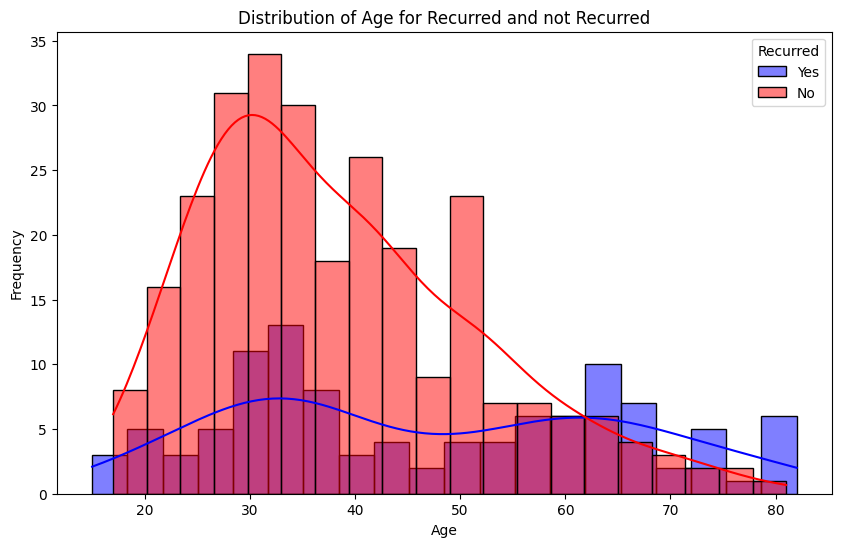

In [15]:
plt.figure(figsize=(10, 6))

# Plot for 'Y' label
sns.histplot(df[df['Recurred'] == 'Yes']['Age'], bins=20, kde=True, color='blue', label='Yes')

# Plot for 'N' label
sns.histplot(df[df['Recurred'] == 'No']['Age'], bins=20, kde=True, color='red', label='No')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age for Recurred and not Recurred')
plt.legend(title='Recurred')
plt.show()


Insight: from those results we can assume that high age might indicated on high probablity for reccuring

We can assume that there's high correltion in Smoking and Hx Smoking so that in this dataset it's not common that a person changed his\her

---\



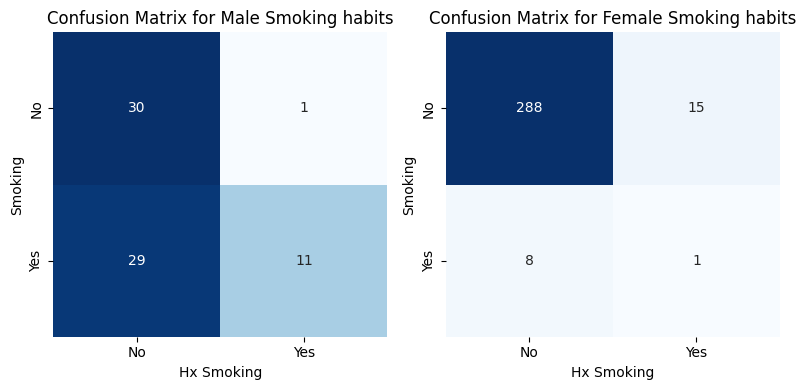

In [75]:
male_df = df[df['Gender'] == 'M']
female_df = df[df['Gender'] == 'F']

male_conf_matrix = pd.crosstab(male_df['Smoking'], male_df['Hx Smoking'])
female_conf_matrix = pd.crosstab(female_df['Smoking'], female_df['Hx Smoking'])

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.heatmap(male_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0])
axs[0].set_title('Confusion Matrix for Male Smoking habits')
axs[0].set_xlabel('Hx Smoking')
axs[0].set_ylabel('Smoking')

sns.heatmap(female_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[1])
axs[1].set_title('Confusion Matrix for Female Smoking habits')
axs[1].set_xlabel('Hx Smoking')
axs[1].set_ylabel('Smoking')

plt.tight_layout()
plt.show()

We can assume that for female there's high correltion in Smoking and Hx Smoking so that in this dataset it's not common that a person changed her Smoking habits for men we can see lower corrletion and more changings in Smoking habits.


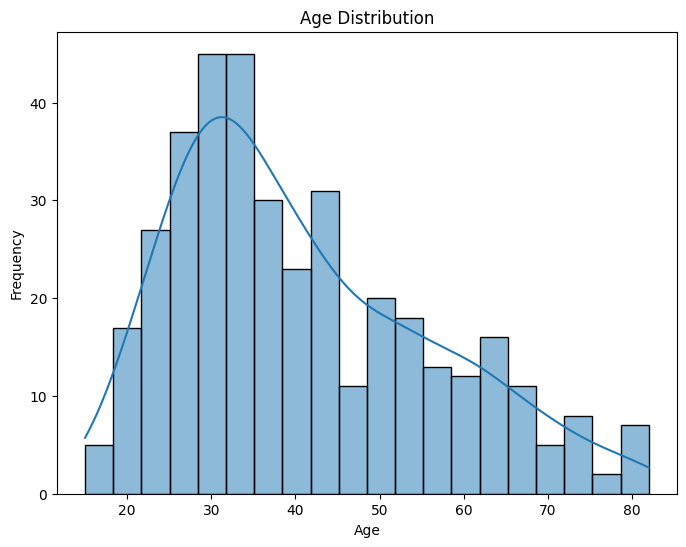

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Hx smoking vs smoking


H0: there's high correltion between 'Hx Smoking' and 'Smoking' so that we can use only of of those features

In [ ]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['Hx Smoking'], df['Recurred'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print("Chi-square value:", chi2)
print("P-value:", p_value)


Chi-square value: 5.977474414669837
P-value: 0.014489737063609615


In [ ]:
# Subset of individuals who smoke and have recurred
df_smoking_recurred = df[(df['Smoking'] == 'Yes') & (df['Recurred'] == 'Yes')]

# Subset of individuals with history of smoking and have recurred
df_hx_smoking_recurred = df[(df['Hx Smoking'] == 'Yes') & (df['Recurred'] == 'Yes')]

# Contingency table for Smoking-Yes and Recurred-Yes vs Hx Smoking-Yes and Recurred-Yes
contingency_table = pd.DataFrame({
    'Smoking-Yes Recurred-Yes': [len(df_smoking_recurred)],
    'Hx Smoking-Yes Recurred-Yes': [len(df_hx_smoking_recurred)]
})

# Chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print("Chi-square value:", chi2)
print("P-value:", p_value)

Chi-square value: 0.0
P-value: 1.0


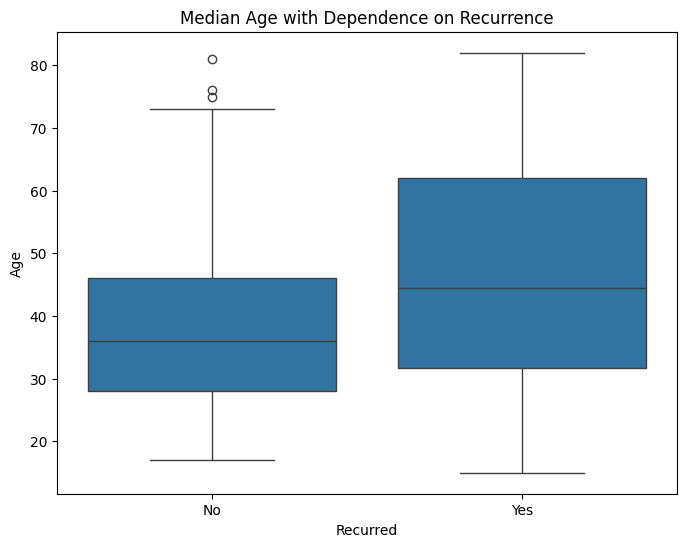

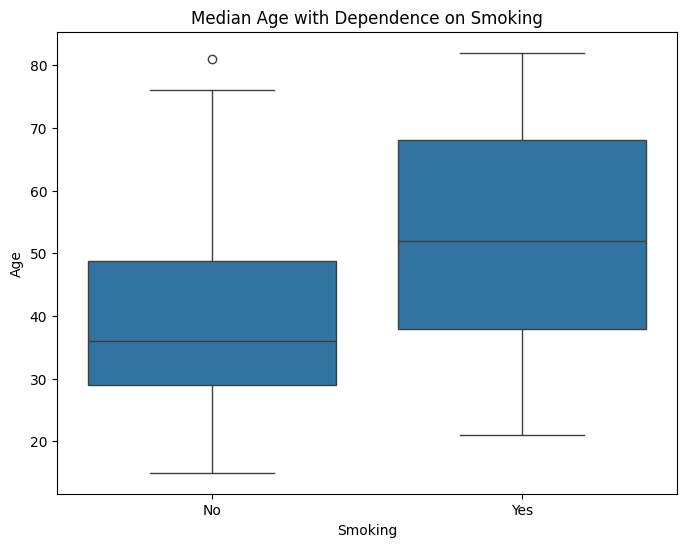

In [ ]:
# # Assuming df is your DataFrame
# num_smoking_yes_hx_smoking_no = df[(df['Smoking'] == 'Yes') & (df['Hx Smoking'] == 'No')].shape[0]
# print("Number of individuals with Smoking='Yes' and Hx Smoking='No':", num_smoking_yes_hx_smoking_no)

# Convert data to DataFrame
df = pd.DataFrame(df)

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Recurred', y='Age', data=df)

# Add labels and title
plt.title('Median Age with Dependence on Recurrence')
plt.xlabel('Recurred')
plt.ylabel('Age')

# Show plot
plt.show()

# Convert data to DataFrame
df = pd.DataFrame(df)

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Smoking', y='Age', data=df)

# Add labels and title
plt.title('Median Age with Dependence on Smoking')
plt.xlabel('Smoking')
plt.ylabel('Age')

# Show plot
plt.show()

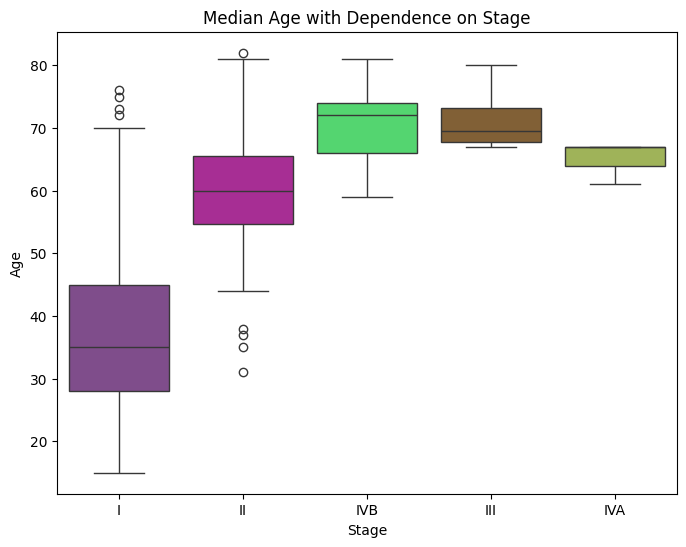

Number of rows where Stage is IVb: 333
Number of rows where Stage is IVb and Recurred is Yes: 65


In [ ]:
# Convert data to DataFrame
df = pd.DataFrame(df)

# Get unique stages
stages = df['Stage'].unique()

# Generate random colors
color_map = {stage: np.random.rand(3,) for stage in stages}

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Stage', y='Age', data=df, palette=color_map)

# Add labels and title
plt.title('Median Age with Dependence on Stage')
plt.xlabel('Stage')
plt.ylabel('Age')

# Show plot
plt.show()

# Convert data to DataFrame
df = pd.DataFrame(df)
stage_IVb_df = df[df['Stage'] == 'I']

# Count the number of rows where Recurred is Yes
recurred_yes_count = stage_IVb_df[stage_IVb_df['Recurred'] == 'Yes'].shape[0]

# Total number of rows where Stage is IVb
total_IVb_count = stage_IVb_df.shape[0]

print("Number of rows where Stage is IVb:", total_IVb_count)
print("Number of rows where Stage is IVb and Recurred is Yes:", recurred_yes_count)

*XGBOOST Model*

Accuracy is: 0.961038961038961


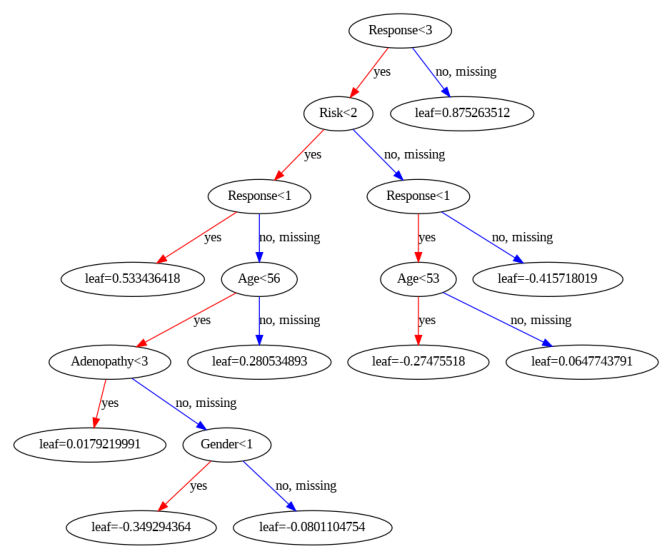

In [59]:
'''
based on the example
https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/
'''

X = df.drop(columns=['Recurred'])
y = df['Recurred']

# adapt categorial classes
label_encoders = {}
for feature in X.select_dtypes(include=['object']).columns:
    label_encoders[feature] = LabelEncoder()
    X[feature] = label_encoders[feature].fit_transform(X[feature])
y = y.replace({'Yes': 1, 'No': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy is:", accuracy)

#an example for a tree
plot_tree(model, num_trees=0, ax=plt.figure(figsize=(12, 7)).add_subplot())
plt.show()